# Topological Data Analysis of CNN Weight Spaces

## Overview

This notebook performs comprehensive topological analysis on CNN weight spaces using persistent homology. We analyze 36,468 trained CNN models from the Merged zoo dataset to understand the geometric and topological structure of neural network weight spaces.

### Dataset Information
- **Total Models**: 36,468 trained CNNs
- **Parameters per Model**: 2,464 (2,416 weights + 48 biases)
- **Activation Functions**: 6 types (gelu, relu, silu, tanh, sigmoid, leakyrelu) - 6,078 models each
- **Training Epochs**: 6 checkpoints (11, 16, 21, 26, 31, 36)
- **MNIST Classes**: 10 digits (0-9), one-hot encoded

### Analysis Strategy

We employ **two complementary grouping strategies** to understand different aspects of the weight space:

#### **Group A: Activation Function Analysis**
Groups models by their activation function to understand how different non-linearities shape the weight space topology.
- 6 groups: gelu, relu, silu, tanh, sigmoid, leakyrelu
- Each group contains 6,078 models
- **Goal**: Identify topological signatures unique to each activation function

#### **Group B: MNIST Class Analysis**
Groups models by which MNIST digit class appears in their training set (using one-hot encoding).
- 10 groups: digits 0-9
- Variable group sizes depending on label combinations
- **Goal**: Detect class-specific topological patterns in weight spaces

### Topological Methods

1. **Vietoris-Rips Persistence**: Compute H0 (connected components) and H1 (loops) persistence diagrams
2. **Distance Metrics**: Bottleneck and Wasserstein distances between persistence diagrams
3. **Vectorized Representations**: Persistence landscapes, Betti curves, persistence images
4. **Epoch Evolution**: Track topological changes across training epochs
5. **Multi-parameter Persistence**: 2D filtration using distance and weight norm

### Computational Considerations

- **Memory Management**: Models are subsampled to 100 per group to manage RAM usage
- **Dimensionality Reduction**: PCA reduces 2,464-d weight vectors to 20-d before persistence computation
- **CPU Optimization**: Parallel processing disabled for gudhi/multipers to avoid thread conflicts
- **Figure Quality**: High-DPI (250) figures with large sizes for readability

### Output Structure

```
figures/05_topology/
├── group_A_activation/     # Activation function analysis results
│   ├── pd_*.png           # Persistence diagrams
│   ├── distances_*.png    # Pairwise distance heatmaps
│   ├── landscapes_*.png   # Persistence landscapes
│   └── *.csv             # Summary statistics
└── group_B_class/         # MNIST class analysis results
    ├── pd_class_*.png
    ├── distances_*.png
    └── *.csv
```

In [14]:
# Cell 0 - Environment Setup and Imports (GUDHI implementation)
# =====================================

%matplotlib inline

import os
import sys
import warnings
import json
import ast
import gc
import re
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Any

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

# Topological Data Analysis (canonical path)
from gudhi import RipsComplex
from gudhi.hera import bottleneck_distance, wasserstein_distance

# Keep this flag for downstream compatibility; pipeline is GUDHI-first.
HAS_GTDA = False

warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

ROOT = Path('/home/aymen/Documents/GitHub/Federated-Continual-learning-/New')
DATA_DIR = ROOT / 'data'
MERGED_ZOO = DATA_DIR / 'Merged zoo.csv'
FIG_DIR = ROOT / 'notebooks_sandbox' / 'figures' / '05_topology'

FIG_DIR_A = FIG_DIR / 'group_A_activation'
FIG_DIR_B = FIG_DIR / 'group_B_class'
FIG_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR_A.mkdir(parents=True, exist_ok=True)
FIG_DIR_B.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
N_SUBSAMPLE = 100
PCA_DIM = 20
MAX_DIM = 1
ACTIVATION_COLS = ['gelu', 'relu', 'silu', 'tanh', 'sigmoid', 'leakyrelu']
DIGIT_COLS = [str(i) for i in range(10)]
EPOCHS = [11, 16, 21, 26, 31, 36]

print('=' * 70)
print('  TOPOLOGICAL DATA ANALYSIS - ENVIRONMENT SETUP')
print('=' * 70)
print(f'Python version: {sys.version}')
print(f'Working directory: {ROOT}')
print(f'Data directory: {DATA_DIR}')
print(f'Figure directory: {FIG_DIR}')
print(f'MERGED_ZOO exists: {MERGED_ZOO.exists()} -> {MERGED_ZOO}')
print('Persistence backend: GUDHI')
print('=' * 70)

  TOPOLOGICAL DATA ANALYSIS - ENVIRONMENT SETUP
Python version: 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]
Working directory: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New
Data directory: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data
Figure directory: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/notebooks_sandbox/figures/05_topology
MERGED_ZOO exists: True -> /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv
Persistence backend: GUDHI


In [15]:
# Cell 0B - Setup sanity check

required_globals = [
    'ROOT', 'DATA_DIR', 'MERGED_ZOO', 'FIG_DIR', 'FIG_DIR_A', 'FIG_DIR_B',
    'RANDOM_SEED', 'N_SUBSAMPLE', 'PCA_DIM', 'MAX_DIM',
    'ACTIVATION_COLS', 'DIGIT_COLS', 'EPOCHS'
]
missing = [k for k in required_globals if k not in globals()]
if missing:
    raise RuntimeError('Run Cell 0 first. Missing: ' + ', '.join(missing))

print('Setup sanity check passed')
print(f'MERGED_ZOO: {MERGED_ZOO}')

Setup sanity check passed
MERGED_ZOO: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv


## Data Loading and Preprocessing

Load the Merged zoo CSV file and prepare it for topological analysis.

**Data Validation Steps**:
1. Load CSV and verify dimensions
2. Extract weight and bias columns (2,464 parameters total)
3. Parse activation function labels (one-hot encoded → string)
4. Parse MNIST class labels (one-hot encoded)
5. Convert epoch and accuracy to numeric types
6. Display sample rows for verification

**Expected Output**: DataFrame with 36,468 rows × 2,483 columns

In [16]:
# Cell 1 - Load and Validate Merged Zoo Data

from pathlib import Path
import pandas as pd
import ast

# Guard against out-of-order execution
if 'ROOT' not in globals():
    ROOT = Path('/home/aymen/Documents/GitHub/Federated-Continual-learning-/New')
if 'DATA_DIR' not in globals():
    DATA_DIR = ROOT / 'data'
if 'MERGED_ZOO' not in globals():
    MERGED_ZOO = DATA_DIR / 'Merged zoo.csv'
if 'ACTIVATION_COLS' not in globals():
    ACTIVATION_COLS = ['gelu', 'relu', 'silu', 'tanh', 'sigmoid', 'leakyrelu']
if 'DIGIT_COLS' not in globals():
    DIGIT_COLS = [str(i) for i in range(10)]

print(f'Loading Merged zoo.csv from: {MERGED_ZOO}')
if not Path(MERGED_ZOO).exists():
    raise FileNotFoundError(f'Merged zoo.csv not found at: {MERGED_ZOO}')

df = pd.read_csv(MERGED_ZOO)

print('Dataset Dimensions:')
print(f'  Rows:    {len(df):,}')
print(f'  Columns: {len(df.columns):,}')

weight_cols = [c for c in df.columns if c.startswith('weight ')]
bias_cols = [c for c in df.columns if c.startswith('bias ')]
param_cols = weight_cols + bias_cols

print('')
print('Parameter Breakdown:')
print(f'  Weights: {len(weight_cols)}')
print(f'  Biases:  {len(bias_cols)}')
print(f'  Total:   {len(param_cols)}')

for c in ACTIVATION_COLS + DIGIT_COLS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').astype(int)

def get_activation(row):
    """Extract activation function name from one-hot encoded columns."""
    for act in ACTIVATION_COLS:
        if row.get(act, 0) == 1:
            return act
    return 'unknown'

df['activation'] = df.apply(get_activation, axis=1)

def parse_label(s):
    """Parse label string into sorted tuple of integers."""
    try:
        return tuple(sorted(ast.literal_eval(s)))
    except Exception:
        return None

df['label_tuple'] = df['label'].apply(parse_label)

print('')
print('Data Validation:')
print(f"  Unique epochs:  {sorted(df['epoch'].unique())}")
print(f"  Unique labels:  {df['label_tuple'].nunique()}")
print('  Activation distribution:')
for act in ACTIVATION_COLS:
    count = (df['activation'] == act).sum()
    print(f'    {act:12s}: {count:5d} models')

print('')
print('MNIST Class distribution (models containing each digit):')
for digit in DIGIT_COLS:
    count = (df[digit] == 1).sum() if digit in df.columns else 0
    print(f'    Digit {digit}: {count:5d} models')

print('')
print('Data loaded successfully!')
print('=' * 70)
print('Sample Data (first 5 rows):')
print('=' * 70)

display_cols = ['label', 'activation', 'epoch', 'Accuracy'] + DIGIT_COLS
display(df[[c for c in display_cols if c in df.columns]].head())

print('')
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loading Merged zoo.csv from: /home/aymen/Documents/GitHub/Federated-Continual-learning-/New/data/Merged zoo.csv
Dataset Dimensions:
  Rows:    36,468
  Columns: 2,483

Parameter Breakdown:
  Weights: 2416
  Biases:  48
  Total:   2464

Data Validation:
  Unique epochs:  [11, 16, 21, 26, 31, 36]
  Unique labels:  1013
  Activation distribution:
    gelu        :  6078 models
    relu        :  6078 models
    silu        :  6078 models
    tanh        :  6078 models
    sigmoid     :  6078 models
    leakyrelu   :  6078 models

MNIST Class distribution (models containing each digit):
    Digit 0: 18396 models
    Digit 1: 18396 models
    Digit 2: 18396 models
    Digit 3: 18396 models
    Digit 4: 18396 models
    Digit 5: 18396 models
    Digit 6: 18396 models
    Digit 7: 18396 models
    Digit 8: 18396 models
    Digit 9: 18396 models

Data loaded successfully!
Sample Data (first 5 rows):


,label,activation,epoch,Accuracy,0,1,2,3,4,5,6,7,8,9
0,"[0, 1]",gelu,36,98.643333,1,1,0,0,0,0,0,0,0,0
1,"[0, 2]",gelu,36,98.906667,1,0,1,0,0,0,0,0,0,0
2,"[0, 3]",gelu,36,98.376667,1,0,0,1,0,0,0,0,0,0
3,"[0, 4]",gelu,36,98.911667,1,0,0,0,1,0,0,0,0,0
4,"[0, 5]",gelu,36,98.868333,1,0,0,0,0,1,0,0,0,0



Memory usage: 698.3 MB


# Cell 2 - Helper Functions for Topological Analysis (canonical)

In [17]:


def subsample_group(df_group, param_cols, n=100, seed=42):
    if len(df_group) <= n:
        return df_group[param_cols].values
    np.random.seed(seed)
    indices = np.random.choice(len(df_group), n, replace=False)
    return df_group.iloc[indices][param_cols].values


def compute_persistence_diagram(X, max_dim=1, max_edge=1.0):
    """GUDHI persistence parser: tuples are (dim, (birth, death))."""
    if len(X) < 3:
        return {0: np.array([]), 1: np.array([])}, None

    rips = RipsComplex(points=X, max_edge_length=max_edge)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim + 2)
    persistence = simplex_tree.persistence()

    diagrams = {}
    for dim in range(max_dim + 1):
        dim_pers = []
        for p_dim, bd in persistence:
            if p_dim != dim:
                continue
            b, d = bd
            if np.isfinite(d) and d > b:
                dim_pers.append((b, d))
        diagrams[dim] = np.array(dim_pers) if dim_pers else np.array([])

    return diagrams, simplex_tree


def plot_persistence_diagrams(diagrams, title="Persistence Diagrams", save_path=None, figsize=(16, 7)):
    fig, axes = plt.subplots(1, len(diagrams), figsize=figsize)
    if len(diagrams) == 1:
        axes = [axes]

    colors = ['#e74c3c', '#3498db']
    for idx, (dim, dgm) in enumerate(diagrams.items()):
        ax = axes[idx]
        if len(dgm) > 0:
            ax.scatter(dgm[:, 0], dgm[:, 1], c=colors[dim], s=30, alpha=0.7, edgecolors='black', linewidth=0.5)
            max_val = max(np.max(dgm), 1.0)
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)
            ax.set_xlim(0, max_val * 1.1)
            ax.set_ylim(0, max_val * 1.1)
        else:
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
        ax.set_xlabel("Birth", fontweight='bold')
        ax.set_ylabel("Death", fontweight='bold')
        ax.set_title(f"H{dim} Persistence", fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=250, bbox_inches='tight')
        print(f"Saved: {save_path.name}")
    plt.show()
    return fig


def persistence_summary(diagrams):
    summary = {}
    for dim, dgm in diagrams.items():
        if len(dgm) > 0:
            persistence = dgm[:, 1] - dgm[:, 0]
            summary[f'H{dim}_n_features'] = len(dgm)
            summary[f'H{dim}_mean_persistence'] = np.mean(persistence)
            summary[f'H{dim}_std_persistence'] = np.std(persistence)
            summary[f'H{dim}_max_persistence'] = np.max(persistence)
            summary[f'H{dim}_total_persistence'] = np.sum(persistence)
        else:
            summary[f'H{dim}_n_features'] = 0
            summary[f'H{dim}_mean_persistence'] = 0
            summary[f'H{dim}_std_persistence'] = 0
            summary[f'H{dim}_max_persistence'] = 0
            summary[f'H{dim}_total_persistence'] = 0
    return summary


def smart_annotate_heatmap(data, ax, fmt=".3f", fontsize=9, threshold=0.1):
    n = data.shape[0]
    if n <= 4:
        for i in range(n):
            for j in range(n):
                if i != j and not np.isnan(data[i, j]):
                    ax.text(j + 0.5, i + 0.5, fmt.format(data[i, j]), ha='center', va='center',
                            fontsize=fontsize, fontweight='bold',
                            color='white' if data[i, j] > threshold else 'black')
    elif n <= 6:
        q = np.nanpercentile(data, 75)
        for i in range(n):
            for j in range(n):
                if i != j and not np.isnan(data[i, j]) and data[i, j] > q:
                    ax.text(j + 0.5, i + 0.5, fmt.format(data[i, j]), ha='center', va='center',
                            fontsize=fontsize, fontweight='bold')

print('Helper functions ready (canonical)')

Helper functions ready (canonical)


In [18]:
# Cell 2B - Deprecated duplicate helper cell

# Intentionally left minimal to avoid overriding canonical helper definitions in Cell 2.
print('Deprecated helper cell skipped. Use Cell 2 (canonical).')

Deprecated helper cell skipped. Use Cell 2 (canonical).


In [ ]:
# Cell 2C - Deprecated duplicate helper block

# Do not execute/maintain duplicate helper definitions here.
# Canonical helper definitions are in Cell 2 (cell index 6).
print('Deprecated duplicate helper block skipped. Use Cell 2 (index 6).')

✓ Helper functions defined successfully


## Group A Execution - Activation Topology

This cell runs actual topological analysis for all activation functions and saves figures/CSVs.

In [ ]:
# Cell 3 - Execute Group A (Activations)

if 'df' not in globals():
    raise RuntimeError('Run Cell 1 (data loading) first.')

activation_diagrams = {}
activation_stats_rows = []

print('=' * 70)
print('GROUP A: ACTIVATION ANALYSIS')
print('=' * 70)

for act in ACTIVATION_COLS:
    df_act = df[df['activation'] == act]
    if len(df_act) < 10:
        print(f'- {act}: skipped (only {len(df_act)} rows)')
        continue

    X = subsample_group(df_act, param_cols, n=min(N_SUBSAMPLE, len(df_act)), seed=RANDOM_SEED)
    X_pca = PCA(n_components=min(PCA_DIM, X.shape[0], X.shape[1]), random_state=RANDOM_SEED).fit_transform(X)
    dgms, _ = compute_persistence_diagram(X_pca, max_dim=MAX_DIM)
    activation_diagrams[act] = dgms

    stats = persistence_summary(dgms)
    stats['group'] = act
    stats['n_models'] = len(df_act)
    activation_stats_rows.append(stats)

    fig_path = FIG_DIR_A / f'pd_activation_{act}.png'
    plot_persistence_diagrams(dgms, title=f'Activation: {act}', save_path=fig_path, figsize=(14, 6))

activation_stats_df = pd.DataFrame(activation_stats_rows)
activation_stats_csv = FIG_DIR_A / 'activation_persistence_summary.csv'
activation_stats_df.to_csv(activation_stats_csv, index=False)

print('')
print(f'Saved: {activation_stats_csv}')
display(activation_stats_df.head())

acts = list(activation_diagrams.keys())
for hdim in range(MAX_DIM + 1):
    n = len(acts)
    if n < 2:
        break
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            d1 = activation_diagrams[acts[i]][hdim]
            d2 = activation_diagrams[acts[j]][hdim]
            if len(d1) > 0 and len(d2) > 0:
                M[i, j] = M[j, i] = wasserstein_distance(d1, d2, order=2)
            else:
                M[i, j] = M[j, i] = np.nan

    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(M, index=acts, columns=acts), cmap='YlOrRd', annot=True, fmt='.3f', square=True)
    plt.title(f'Group A Wasserstein Distances (H{hdim})')
    plt.tight_layout()
    out = FIG_DIR_A / f'activation_wasserstein_H{hdim}.png'
    plt.savefig(out, dpi=250)
    plt.show()

    csv_out = FIG_DIR_A / f'activation_wasserstein_H{hdim}.csv'
    pd.DataFrame(M, index=acts, columns=acts).to_csv(csv_out)
    print(f'Saved: {csv_out}')

GROUP A: ACTIVATION ANALYSIS


ValueError: not enough values to unpack (expected 3, got 2)

## Group B Execution - MNIST Class Topology

This cell runs topology analysis per digit-class group (0-9) and saves figures/CSVs.

GROUP B: MNIST CLASS ANALYSIS
  ✓ Saved: pd_digit_0.png


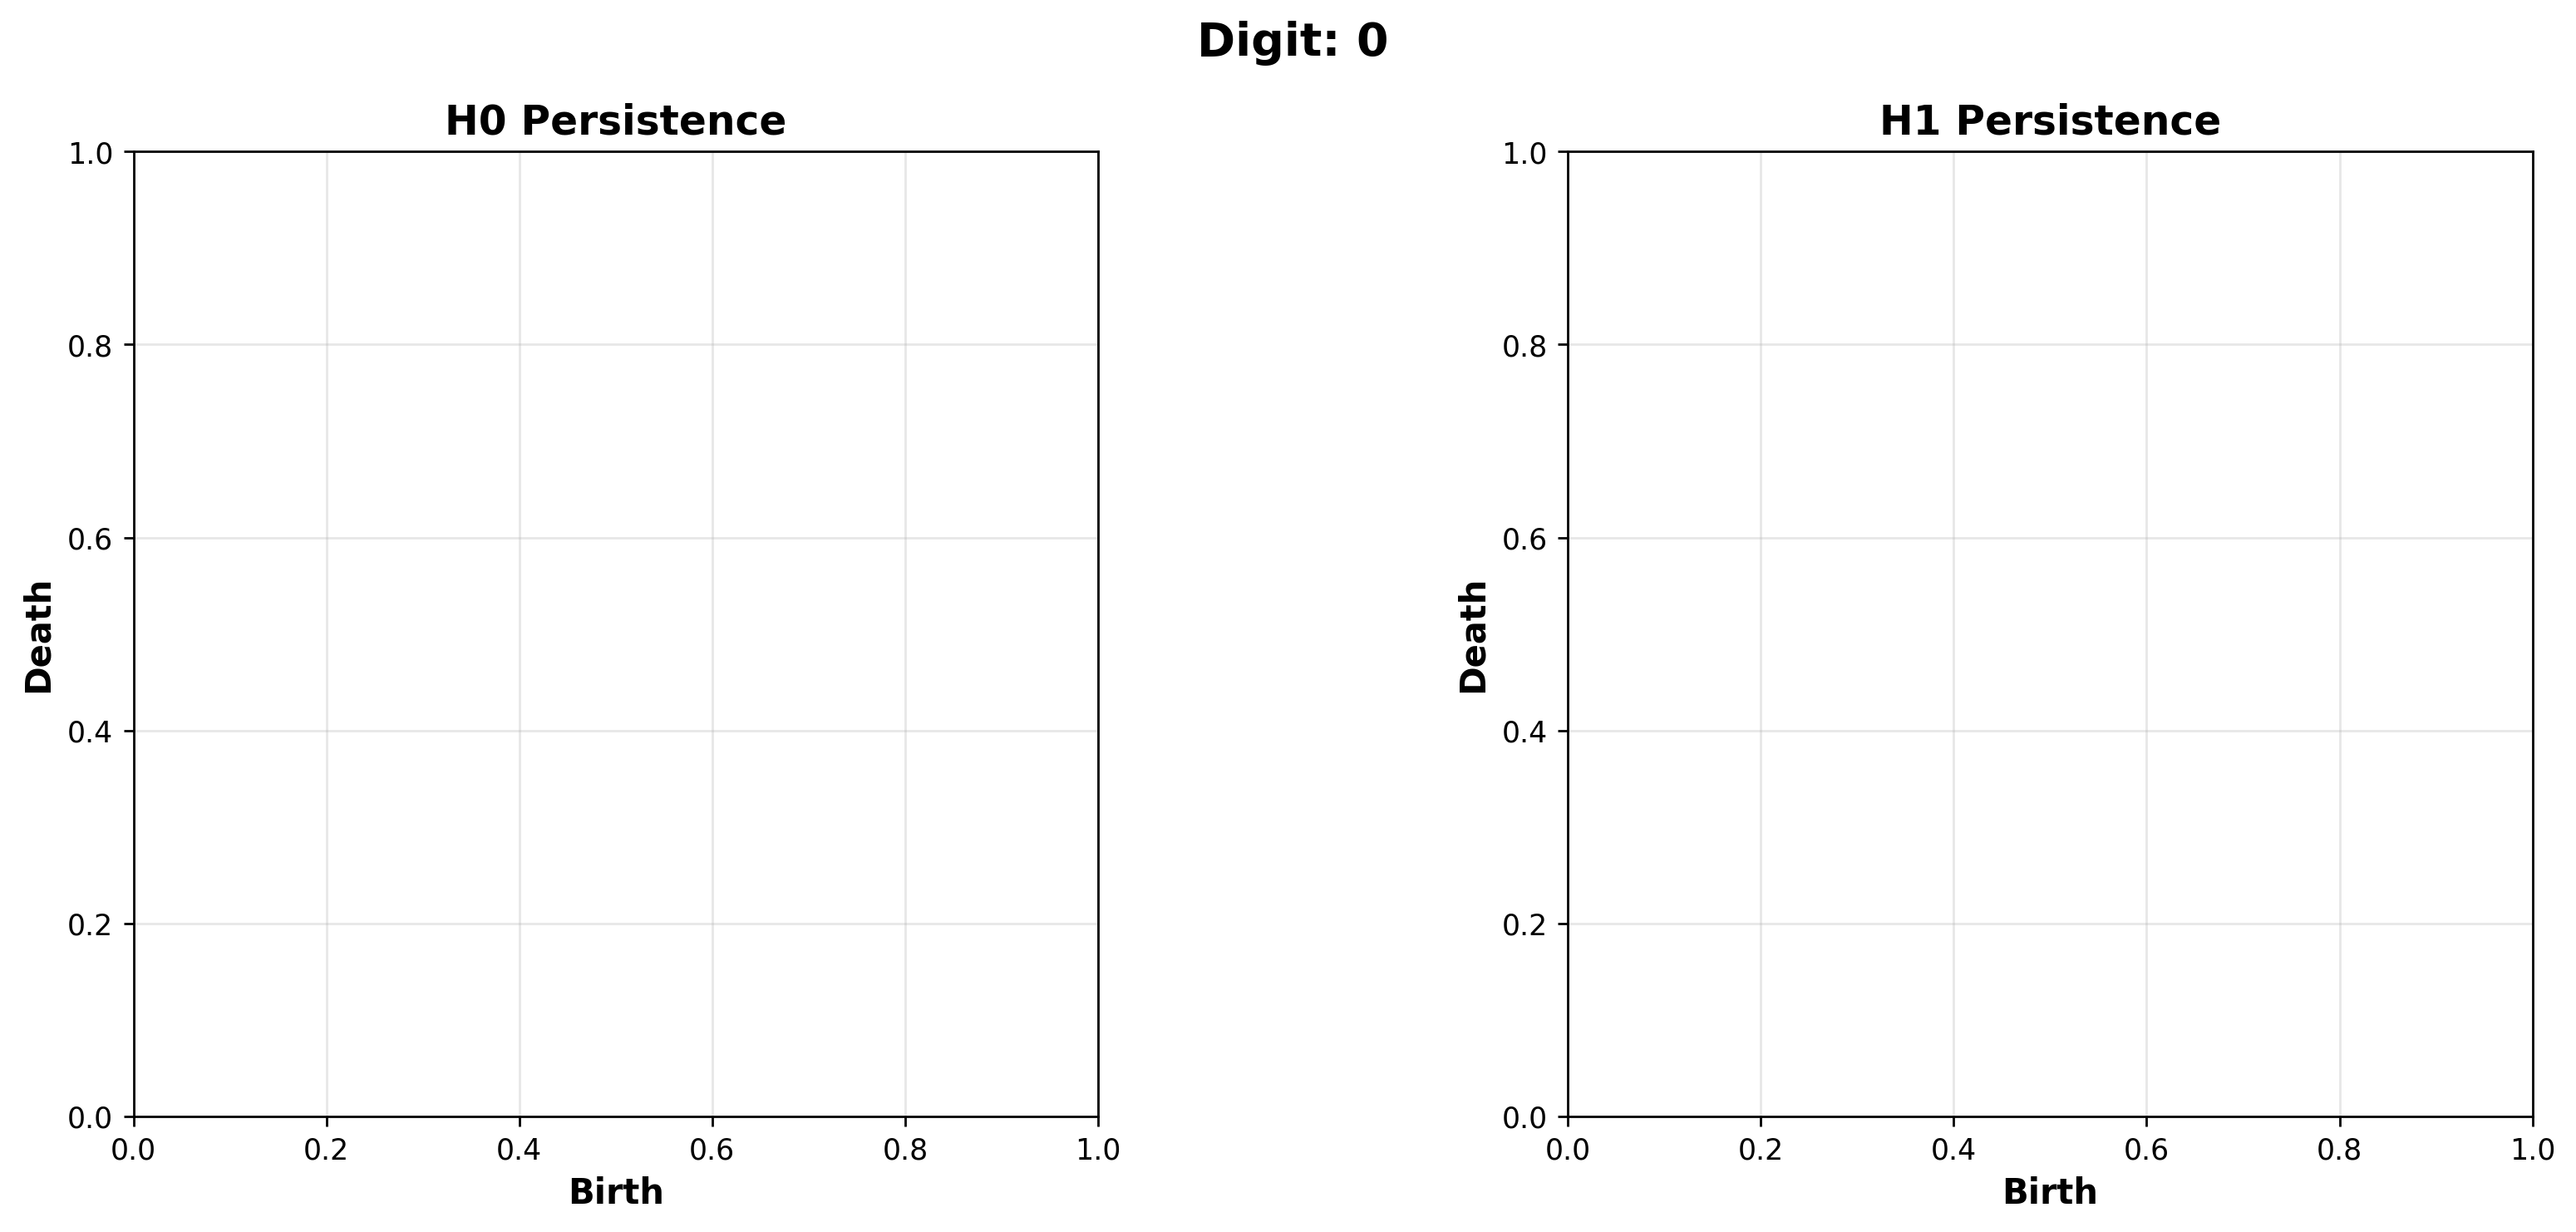

  ✓ Saved: pd_digit_1.png


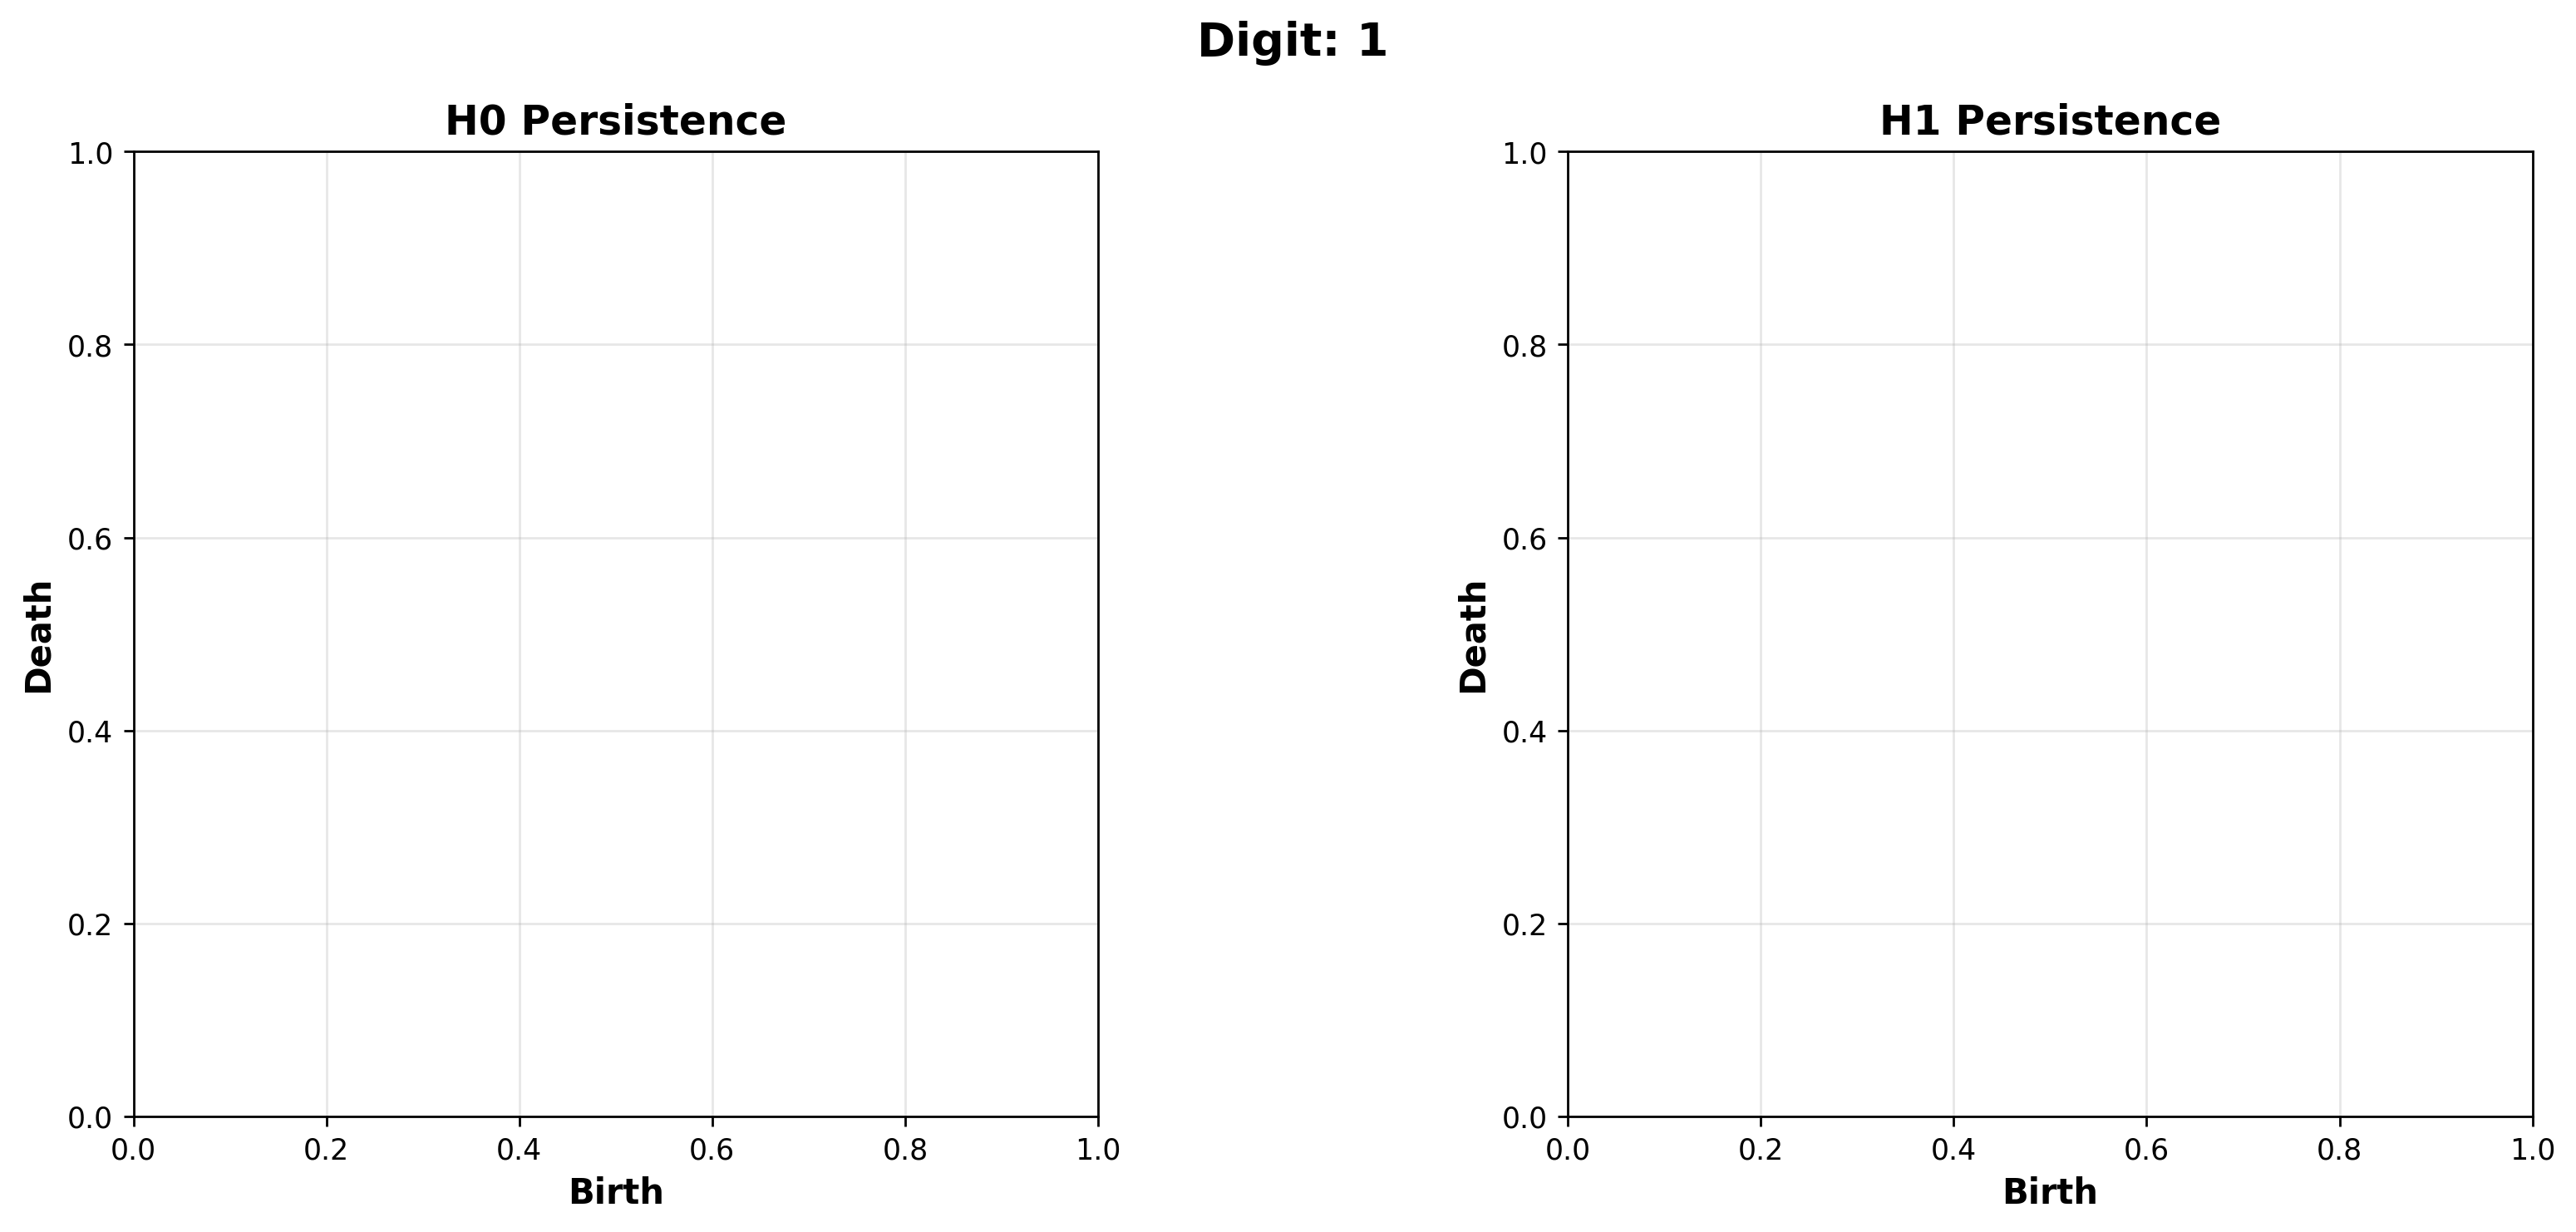

  ✓ Saved: pd_digit_2.png


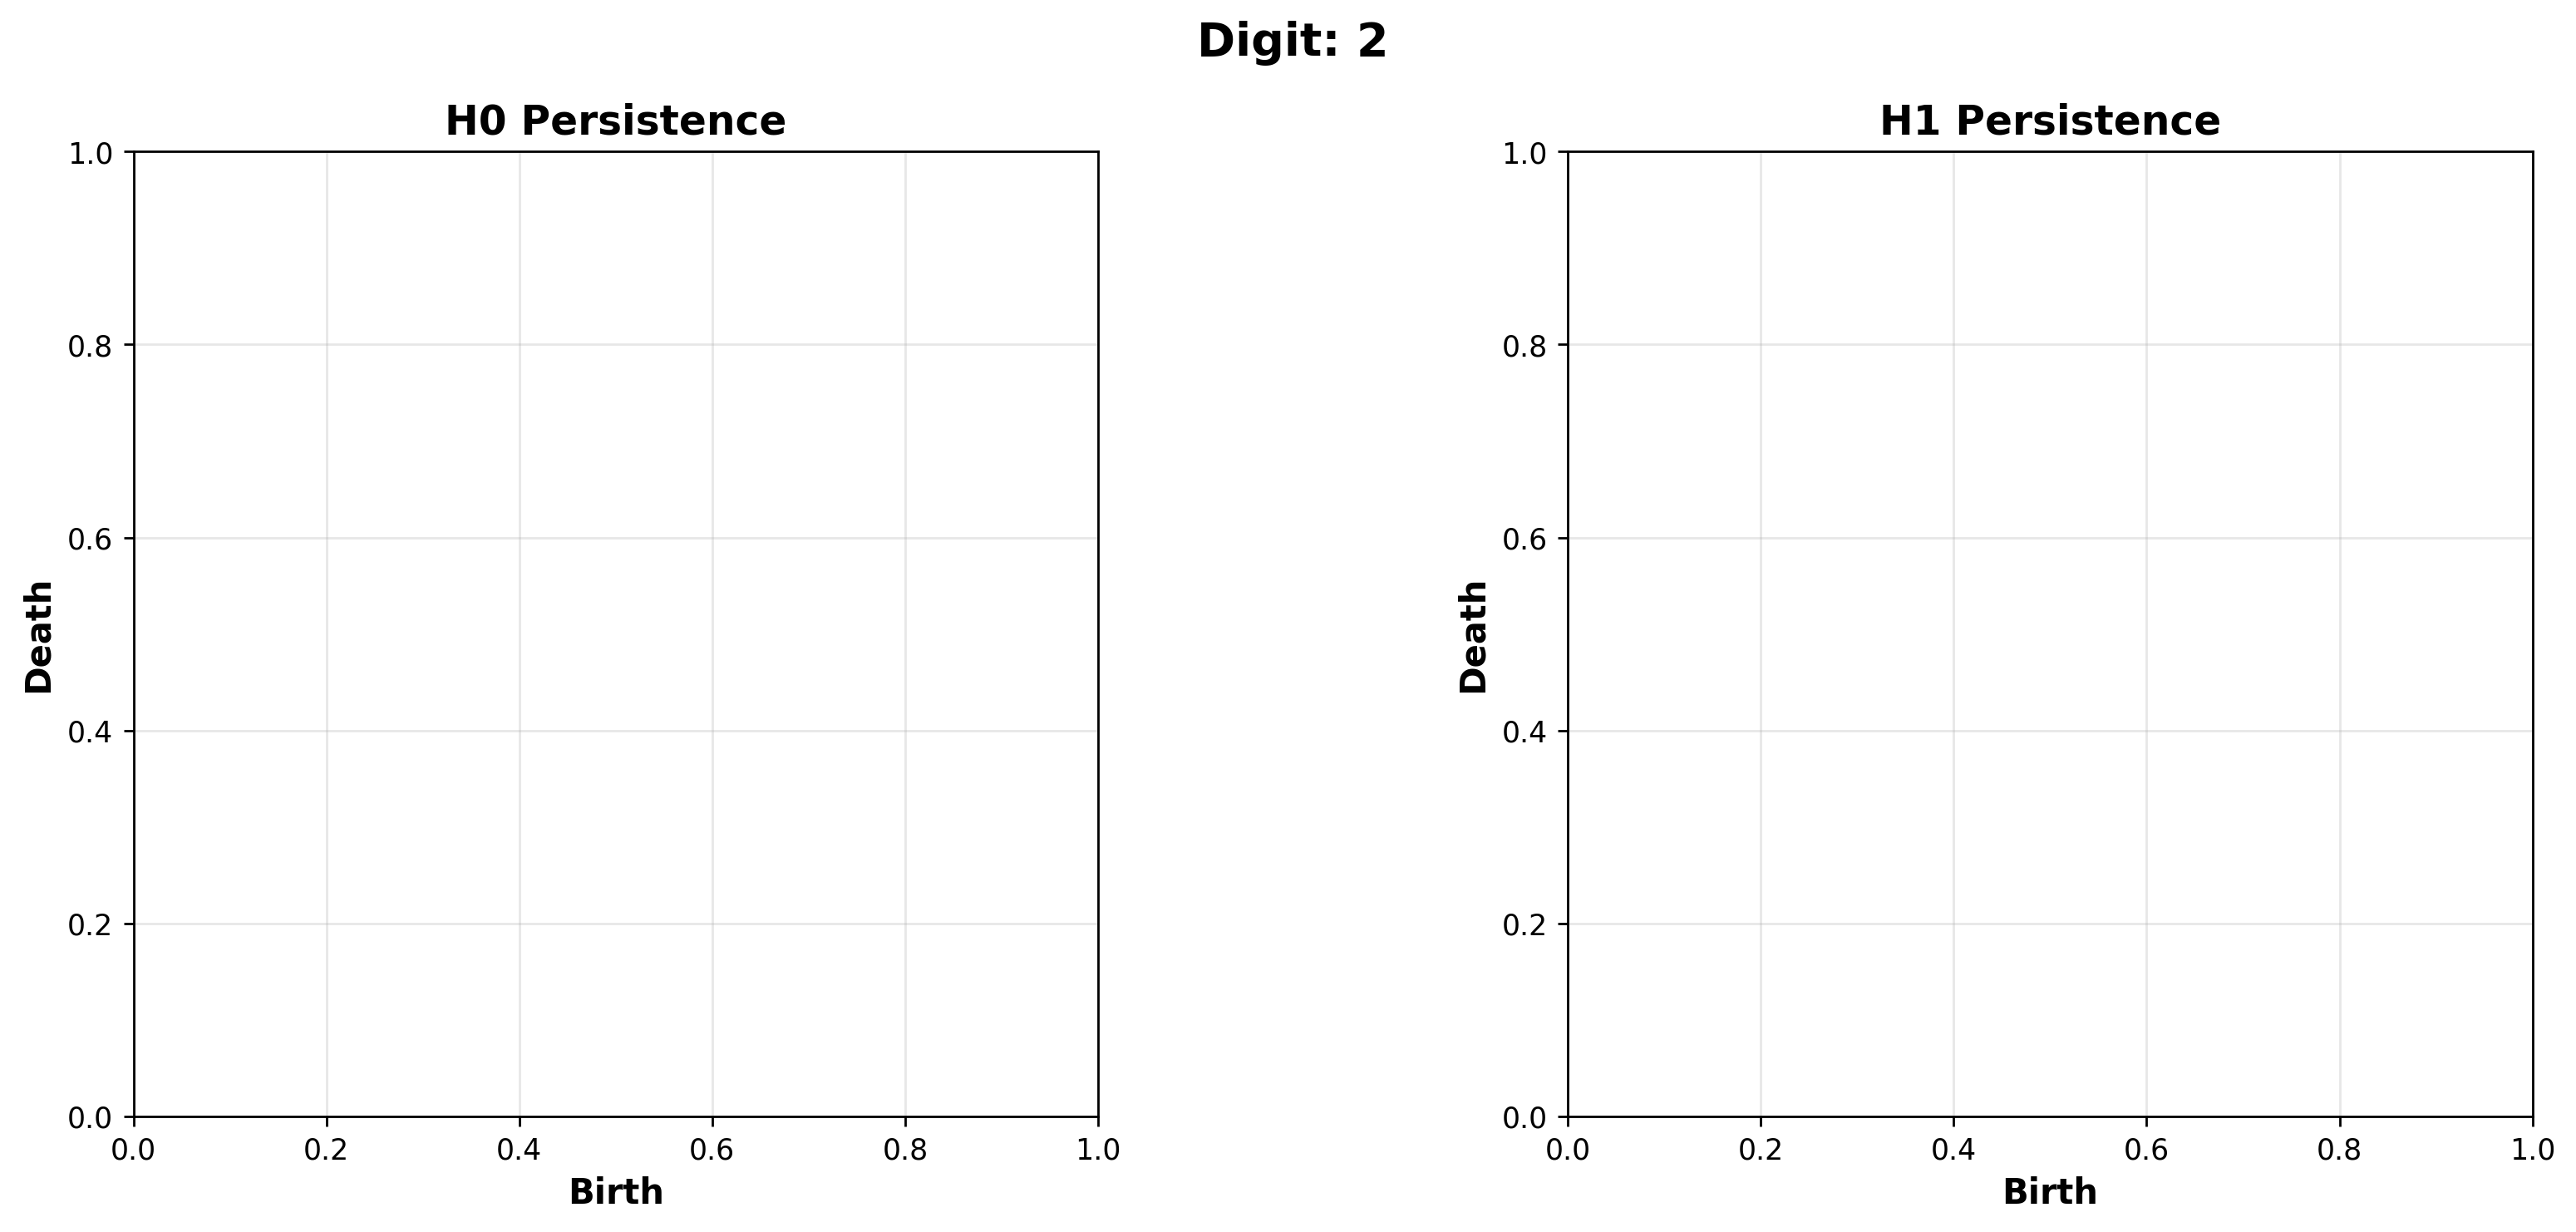

  ✓ Saved: pd_digit_3.png


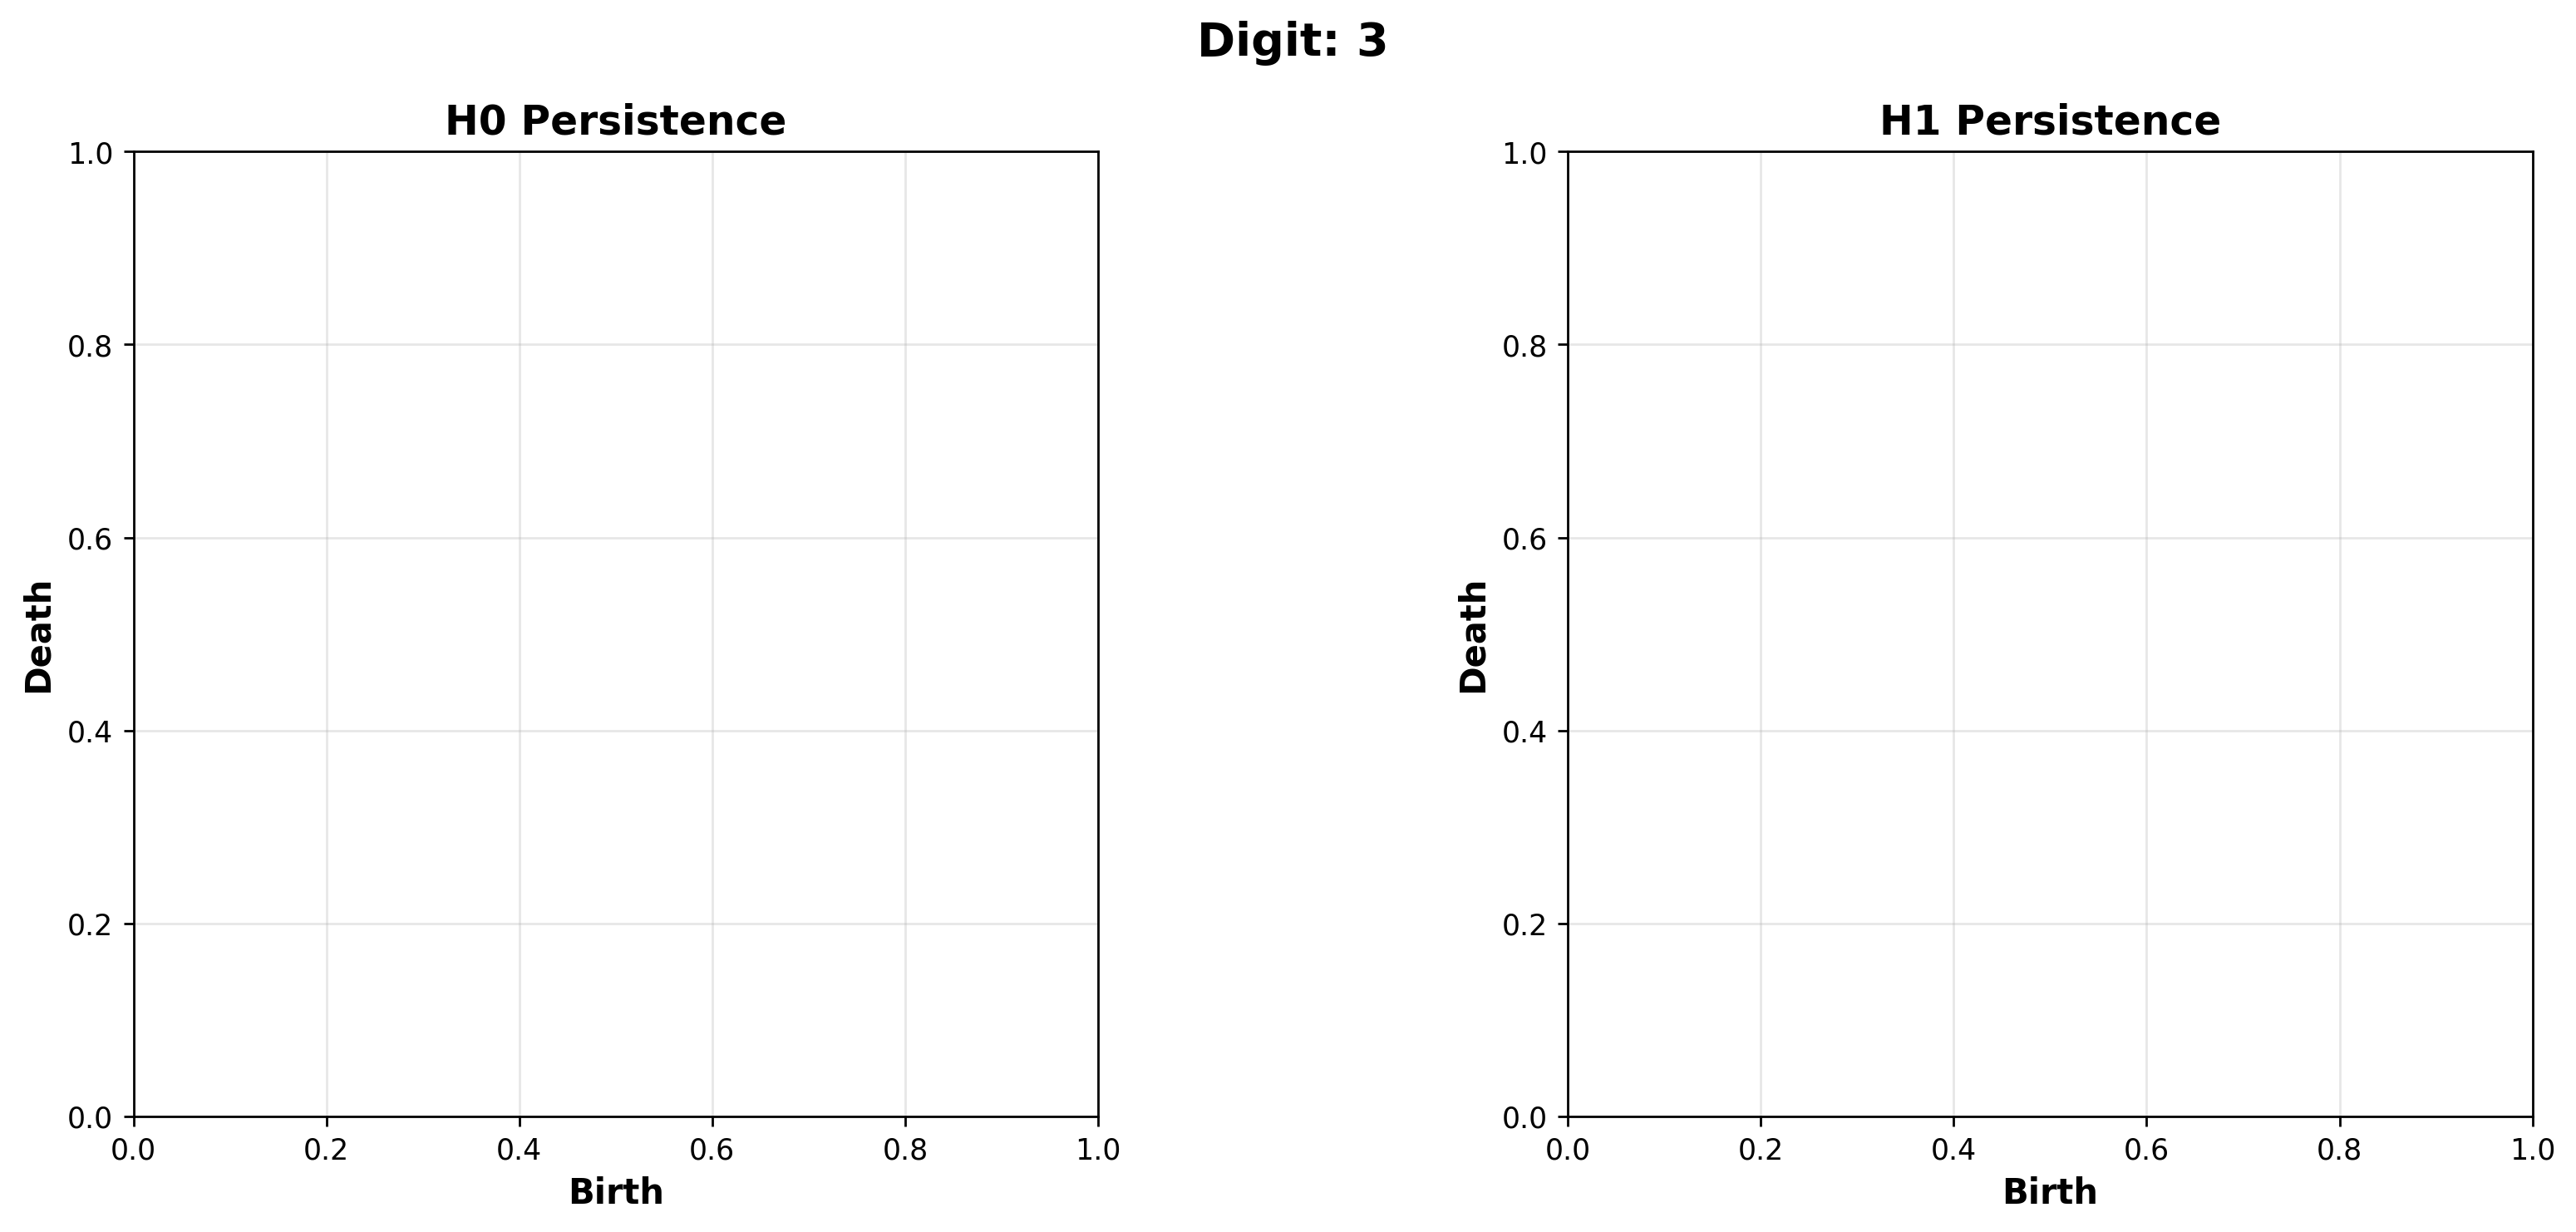

  ✓ Saved: pd_digit_4.png


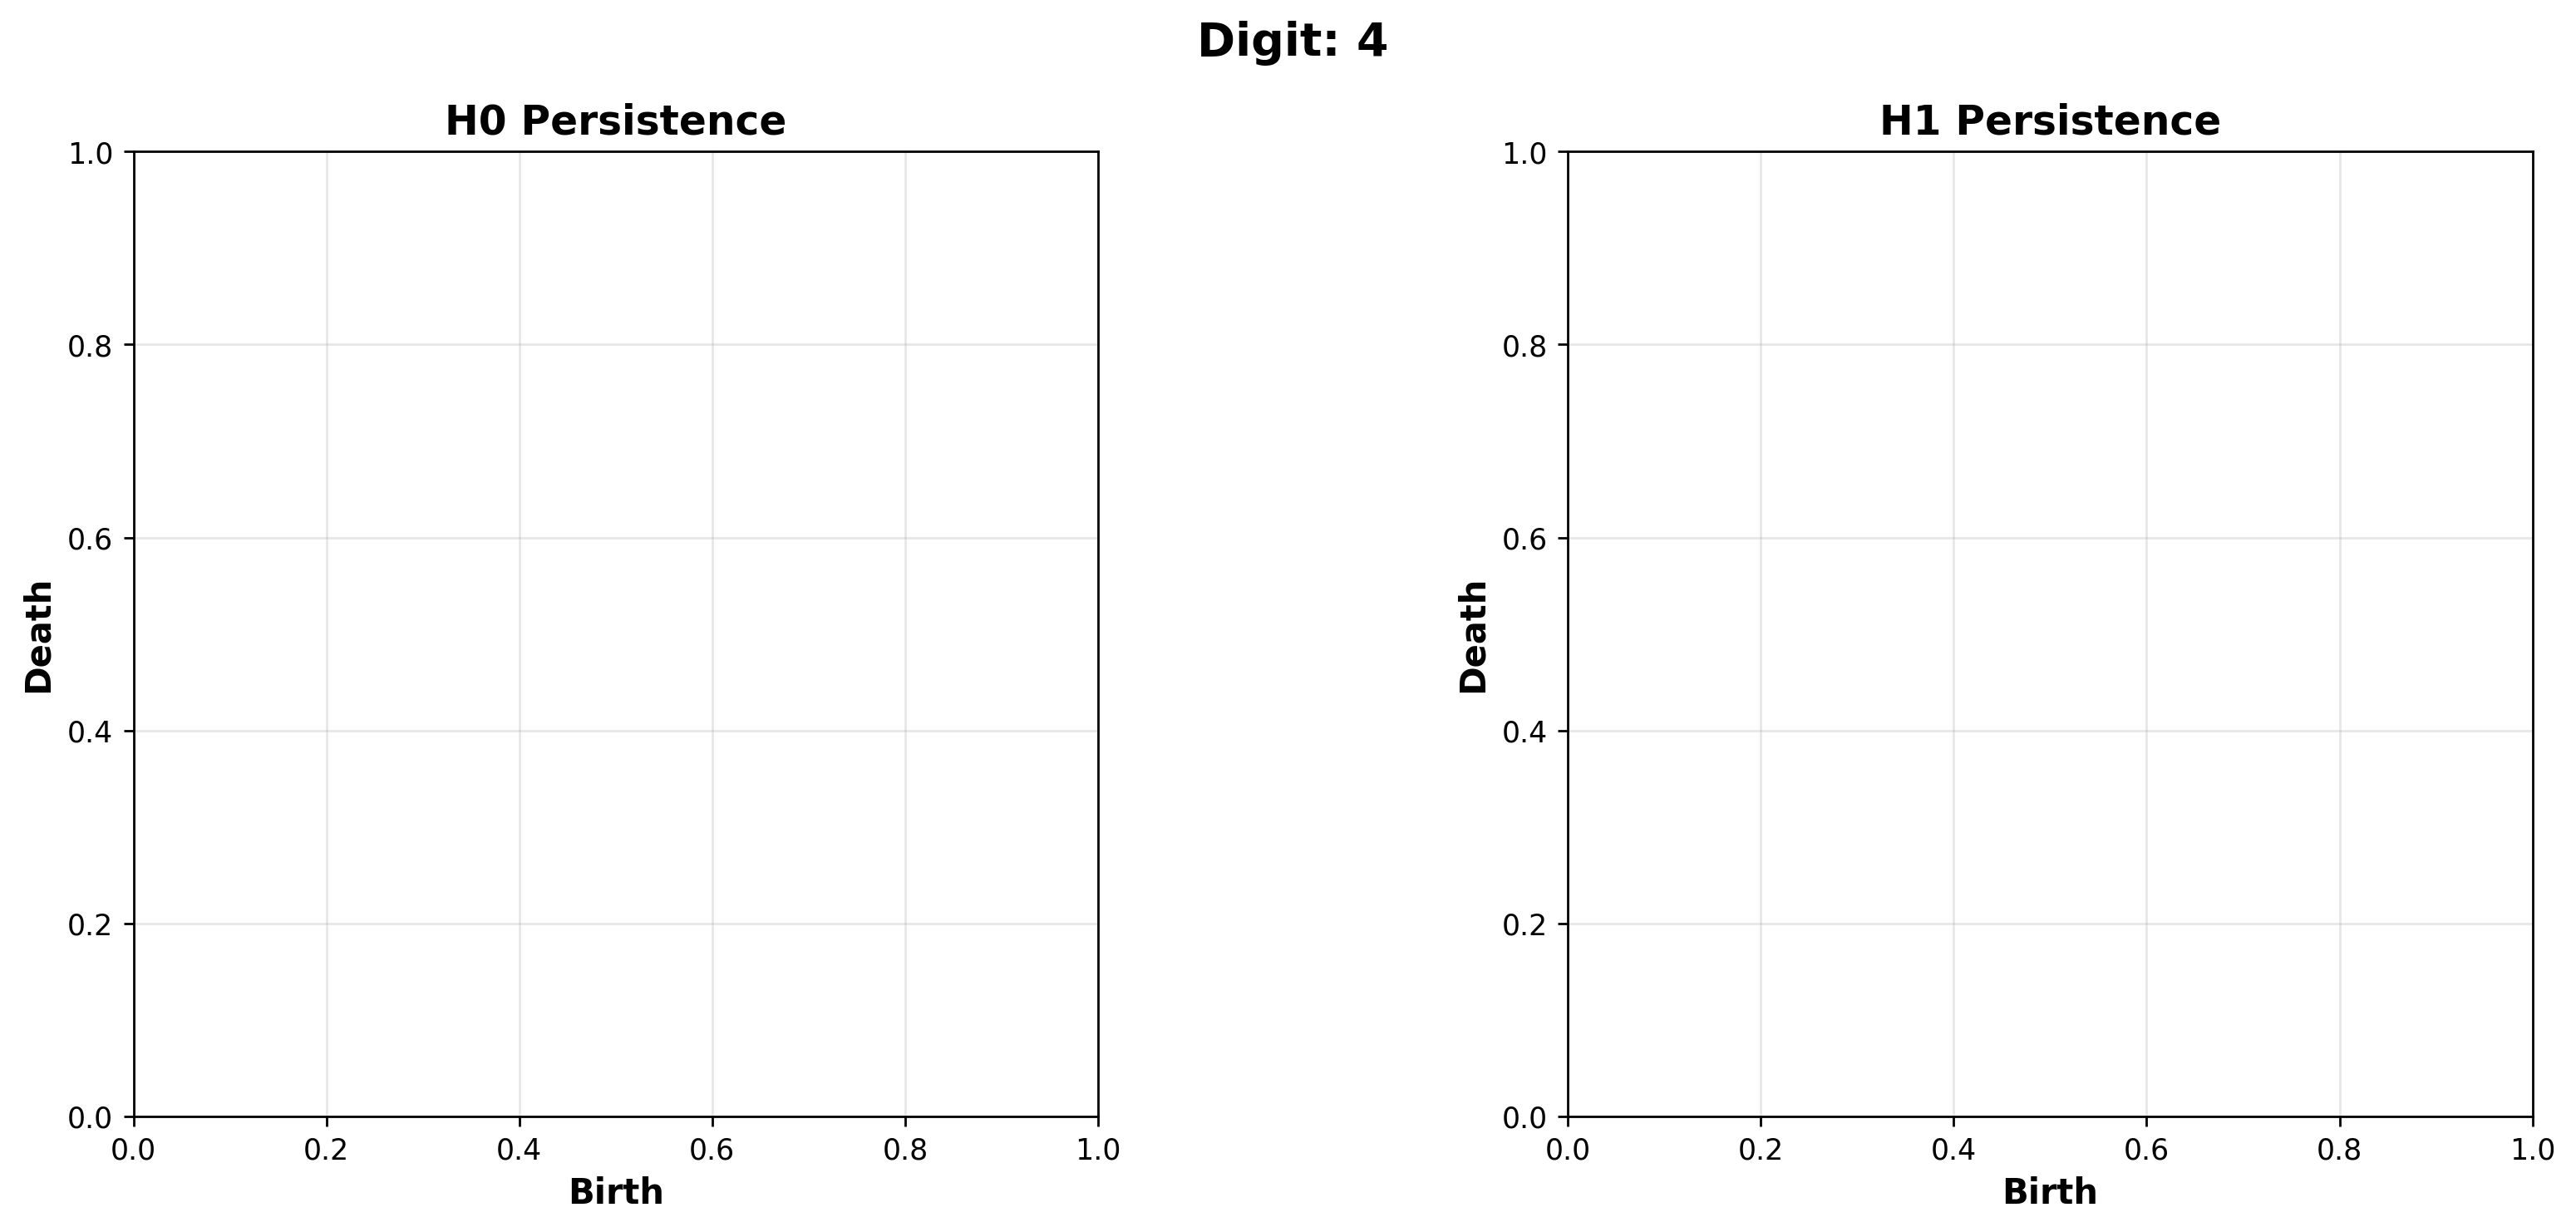

ValueError: not enough values to unpack (expected 3, got 2)

In [12]:
# Cell 4 - Execute Group B (MNIST class groups)

if 'df' not in globals():
    raise RuntimeError('Run Cell 1 (data loading) first.')

class_diagrams = {}
class_stats_rows = []

print('=' * 70)
print('GROUP B: MNIST CLASS ANALYSIS')
print('=' * 70)

for digit in DIGIT_COLS:
    if digit not in df.columns:
        continue
    df_d = df[df[digit] == 1]
    if len(df_d) < 10:
        print(f'- digit {digit}: skipped (only {len(df_d)} rows)')
        continue

    X = subsample_group(df_d, param_cols, n=min(N_SUBSAMPLE, len(df_d)), seed=RANDOM_SEED)
    X_pca = PCA(n_components=min(PCA_DIM, X.shape[0], X.shape[1]), random_state=RANDOM_SEED).fit_transform(X)
    dgms, _ = compute_persistence_diagram(X_pca, max_dim=MAX_DIM)
    class_diagrams[digit] = dgms

    stats = persistence_summary(dgms)
    stats['group'] = digit
    stats['n_models'] = len(df_d)
    class_stats_rows.append(stats)

    fig_path = FIG_DIR_B / f'pd_digit_{digit}.png'
    plot_persistence_diagrams(dgms, title=f'Digit: {digit}', save_path=fig_path, figsize=(14, 6))

class_stats_df = pd.DataFrame(class_stats_rows)
class_stats_csv = FIG_DIR_B / 'digit_persistence_summary.csv'
class_stats_df.to_csv(class_stats_csv, index=False)

print('')
print(f'Saved: {class_stats_csv}')
display(class_stats_df.head())

# Pairwise Wasserstein distance heatmaps (H0/H1)
digits = list(class_diagrams.keys())
for hdim in range(MAX_DIM + 1):
    n = len(digits)
    if n < 2:
        break
    M = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            d1 = class_diagrams[digits[i]][hdim]
            d2 = class_diagrams[digits[j]][hdim]
            if len(d1) > 0 and len(d2) > 0:
                M[i, j] = M[j, i] = wasserstein_distance(d1, d2, order=2)
            else:
                M[i, j] = M[j, i] = np.nan

    plt.figure(figsize=(10, 8))
    sns.heatmap(pd.DataFrame(M, index=digits, columns=digits), cmap='YlGnBu', annot=False, square=True)
    plt.title(f'Group B Wasserstein Distances (H{hdim})')
    plt.tight_layout()
    out = FIG_DIR_B / f'class_wasserstein_H{hdim}.png'
    plt.savefig(out, dpi=250)
    plt.show()

    csv_out = FIG_DIR_B / f'class_wasserstein_H{hdim}.csv'
    df_dist = pd.DataFrame(M, index=digits, columns=digits)
    df_dist.to_csv(csv_out)
    print(f'Saved: {csv_out}')
    display(df_dist.head())

In [ ]:
# Cell 2D - Deprecated duplicate helper block

# Do not execute/maintain duplicate helper definitions here.
# Canonical helper definitions are in Cell 2 (cell index 6).
print('Deprecated duplicate helper block skipped. Use Cell 2 (index 6).')

✓ Helper functions defined successfully
